# Analyse des valeurs obtenues avec les différentes mesures

Ce notebook a pour objectif d'analyser au mieux les différentes mesures calculées puis sauvegardées au préalable afin de mieux approcher un nombre de clusters $k$ optimal 

In [1]:
import numpy as np
import pandas as pd
import pickle as pkl

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,10)

In [60]:
nodeType, relType, version, use_weights = "Namespace", "CONTAINS", "V3", False

In [61]:
str_weight = 'W' if use_weights and relType in {'USE_NS','USE_TYPE'} else ''

graph_suffix = f"{relType}{version}{str_weight}"

 Namespaces à enlever selon la version :
 
* V1 -> Aucune restriction
* V2 -> Pas de namespace lié à la DPD
* V3 -> V2 + pas de namespace lié à PRO
* V4 -> V3 + pas de namespace lié à INTERFACES

In [62]:
if version == "V1":
    remove_ns = []
elif version == "V2":
    remove_ns = ['dpd']
elif version == "V3":
    remove_ns = ['dpd','pro']
elif version == "V4":
    remove_ns = ['dpd','pro','interfaces']

#### Chargement des données

In [63]:
#Si jamais les fichiers sont dans un autre dossier
folder = ""

#Récupération des valeurs propres
vp = pkl.load(open(f"{folder}VP{graph_suffix}.pkl","rb"))
vp[0] = 0
vp_bins = [0.1*x for x in range(21)] #Intervalles entre 0 et 2 (inclus) par intervalle de 0.1
N_vp = vp.shape[0]

#Récupération des valeurs d'inertie
inertia = pkl.load(open(f"{folder}inertia{graph_suffix}.pkl","rb"))
N_in = inertia.shape[0]

#Récupération des silhouette score
silh = pkl.load(open(f"{folder}silh{graph_suffix}.pkl","rb"))
N_silh = silh.shape[0]

In [64]:
N_vp, N_in, N_silh

(50, 48, 48)

#### Chargement des valeurs random moyennes

In [ ]:
randIn = pkl.load(open(f"{folder}randInertia{graph_suffix}.pkl","rb"))
randSilh = pkl.load(open(f"{folder}randSilh{graph_suffix}.pkl","rb"))
#randVp = pkl.load(open(f"{folder}randVp{graph_suffix}.pkl","rb"))

----- 

In [8]:
def get_graph_info(offset_left=0,offset_right=0):
    """
    Fonction pour définir le suffixe des figures matplotlib
    """
    str_zoom = "zoom" if offset_left + offset_right != 0 else ""
    str_ns = " ".join(list(map(lambda s: "no "+s, remove_ns)))

    if str_zoom + str_ns != "":
        graph_info = f'({str_ns}{", " if str_ns != "" and str_zoom != "" else ""}{str_zoom})'
    else:
        graph_info = ""
        
    return graph_info

### Allure des valeurs propres

In [9]:
vp_x = min(40, N_vp)
vp_range = range(vp_x)

#### Echelle linéaire

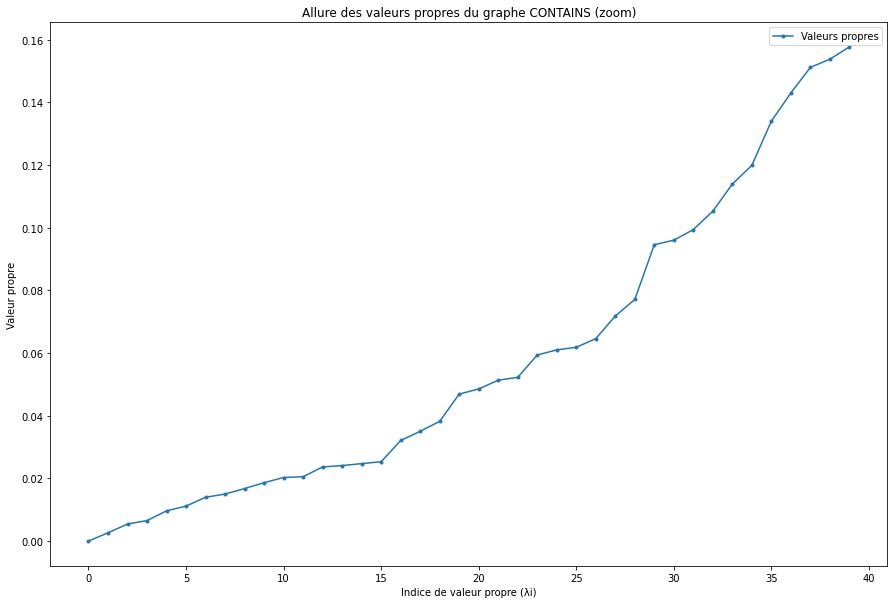

In [10]:
plt.title(f"Allure des valeurs propres du graphe {relType} {get_graph_info(0,N_vp-vp_x)}")
plt.xlabel('Indice de valeur propre (λi)')
plt.ylabel('Valeur propre')

#Plot vp graphe
plt.plot(vp_range, vp[:vp_x], marker=".", label="Valeurs propres")

#Plot vp random
#plt.plot(vp_range, randVp[:vp_x], marker=".", label="Valeurs propres (graphes random)")

plt.legend()

#Sauvegarde du graphique
#plt.savefig(f"vp{graph_suffix}{"zoom" if vp_x<N_vp else ""}.png")

#### Echelle logarithmique

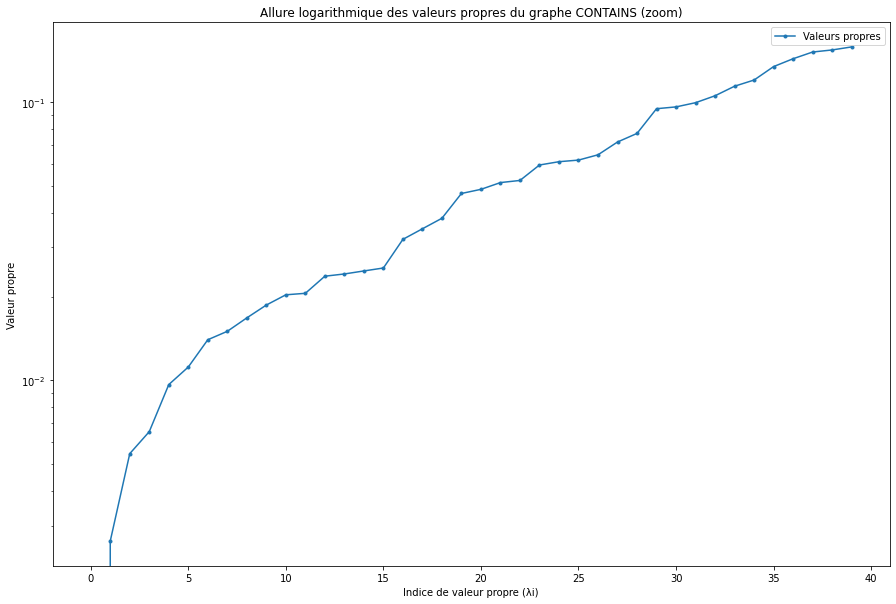

In [11]:
plt.title(f"Allure logarithmique des valeurs propres du graphe {relType} {get_graph_info(0,N_vp-vp_x)}")
plt.xlabel('Indice de valeur propre (λi)')
plt.ylabel('Valeur propre')
plt.yscale("log")

#Plot vp graphe
plt.plot(vp_range, vp[:vp_x], marker=".", label="Valeurs propres")

#Plot vp random
#plt.plot(vp_range, randVp[:vp_x], marker=".", label="Valeurs propres (graphes random)")

plt.legend()

#Sauvegarde du graphique
#plt.savefig(f"vpLog{graph_suffix}{"zoom" if vp_x<N_vp else ""}.png")

#### Delta entre chaque valeur propre

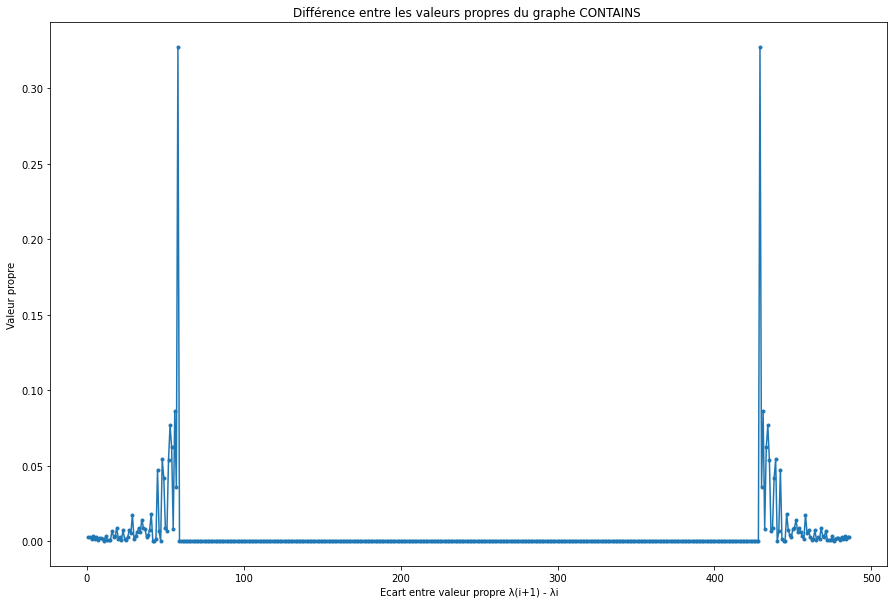

In [12]:
plt.title(f"Différence entre les valeurs propres du graphe {relType} {get_graph_info()}")
plt.xlabel('Ecart entre valeur propre λ(i+1) - λi')
plt.ylabel('Valeur propre')
plt.plot(range(1,N_vp), np.diff(vp), marker=".")

#Sauvegarde du graphique
#plt.savefig(f"vpDiff{graph_suffix}.png")

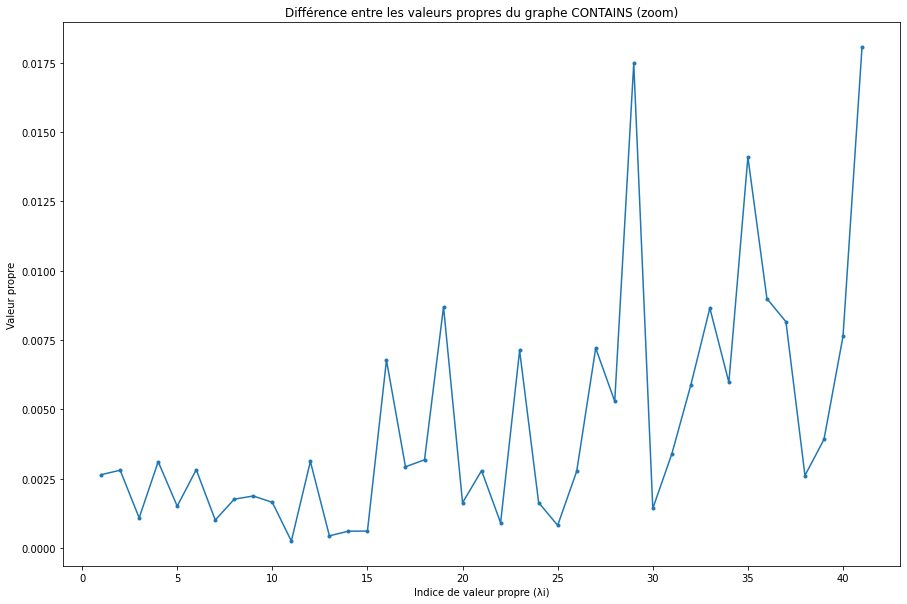

In [13]:
vp_diff = np.diff(vp)
cut_i = vp_diff.shape[0]-1

for i in range(vp_diff.shape[0]):
    if vp_diff[i] <= 10e-10:
        cut_i = i-1
        break
        
vp_diff = vp_diff[:cut_i]

plt.title(f"Différence entre les valeurs propres du graphe {relType} {get_graph_info(0,cut_i)}")
plt.xlabel('Indice de valeur propre (λi)')
plt.ylabel('Valeur propre')
plt.plot(range(1,vp_diff.shape[0]+1), vp_diff, marker=".")

#Sauvegarde du graphique
#plt.savefig(f"vpDiffZoom{graph_suffix}.png")

# Graphe cumulé

#### Regroupement des valeurs propres par intervalles

In [14]:
vals, bins_h = np.histogram(vp, bins=vp_bins)

#### Calcul et affichage du graphe cumulé

In [15]:
cumule = np.zeros(len(bins_h))

cumule[1:] = np.cumsum(vals)/N_vp

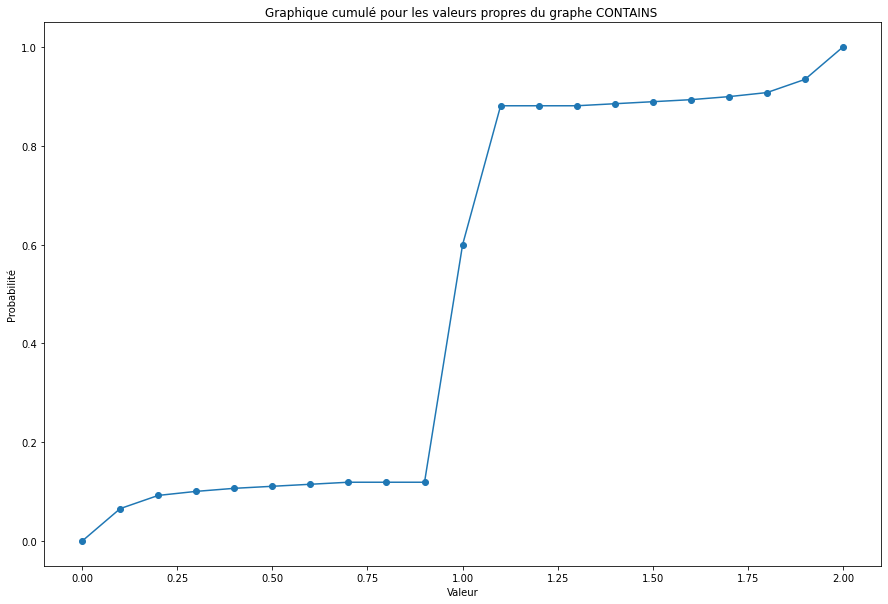

In [16]:
plt.title(f"Graphique cumulé pour les valeurs propres du graphe {relType} {get_graph_info()}")
plt.xlabel("Valeur")
plt.ylabel("Probabilité")
plt.plot(bins_h, cumule, marker="o")

#Sauvegarde du graphique
#plt.savefig(f"cumule{graph_suffix}.png")

#### Calcul du sigmoïde pour le graphe cumulé

In [17]:
from scipy.optimize import curve_fit

In [18]:
def fsigmoid(x, a, b):
    """Formule de la fonction sigmoïde"""
    return 1.0 / (1.0 + np.exp(-a*(x-b)))

popt, pcov = curve_fit(fsigmoid, bins_h, cumule, method='dogbox')

#### Calcul des dérivées du sigmoïde

In [19]:
from scipy.misc import derivative

In [20]:
def deriv_sig(x,deg=1):
    """Calcule la dérivée de la fonction sigmoïde"""
    return derivative(lambda z: fsigmoid(z, *popt), x, n=deg)

#### Trouver l'endroit où la dérivée passe par 0

In [21]:
cross_indexes = [] #Points qui passent par 0
dec_ind = [] #Points de décélération

for i in range(len(bins_h)-1):
    #Décélération
    if deriv_sig(bins_h[i],2) >= 0 and deriv_sig(bins_h[i+1],2) < 0:
        dec_ind.append(i+1)

In [22]:
list(sorted(dec_ind))

[10]

#### Affichage de la dérivée du graphe cumulé

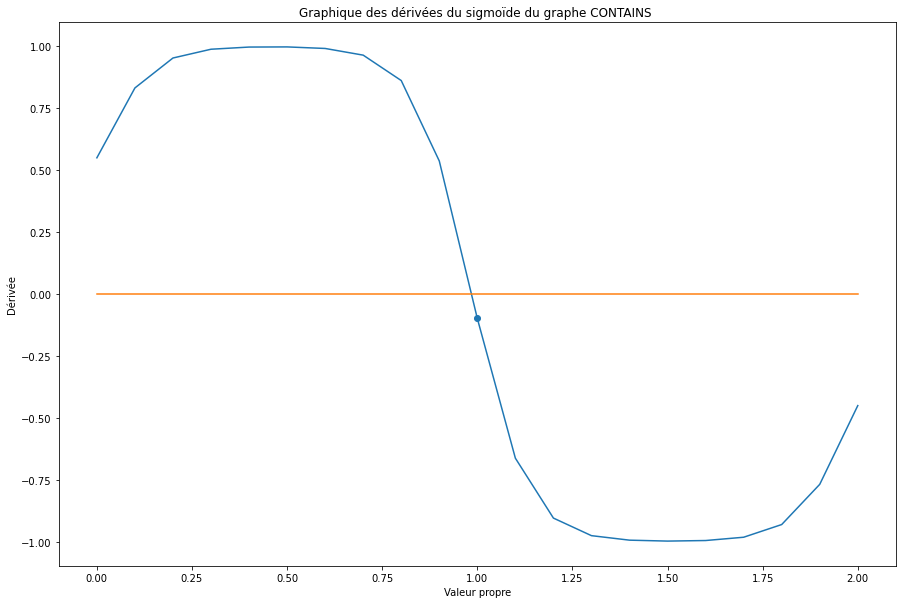

In [23]:
plt.title(f"Graphique des dérivées du sigmoïde du graphe {relType} {get_graph_info()}")
plt.xlabel("Valeur propre")
plt.ylabel("Dérivée")
plt.plot(bins_h, deriv_sig(bins_h,2))
plt.plot(bins_h,np.zeros(bins_h.shape))
plt.scatter(bins_h[dec_ind], [deriv_sig(bins_h[val],2) for val in dec_ind])

#Sauvegarde du graphique
#plt.savefig(f"cumuleDer{graph_suffix}.png")

#### Affichage du sigmoïde du graphe cumulé

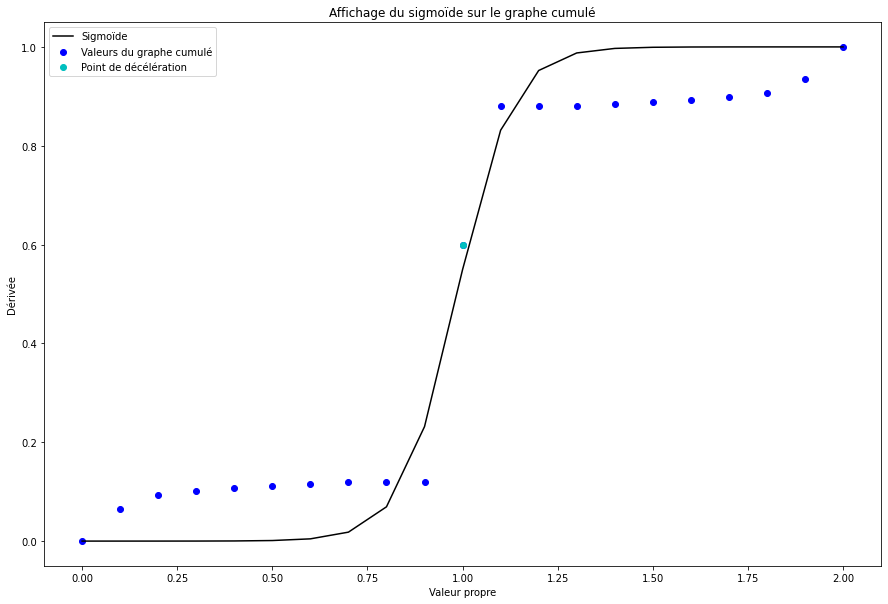

In [24]:
y = fsigmoid(bins_h, *popt)

plt.title("Affichage du sigmoïde sur le graphe cumulé")
plt.xlabel("Valeur propre")
plt.ylabel("Dérivée")
plt.plot(bins_h, y, color="k", label = "Sigmoïde")
plt.scatter(bins_h, cumule, color="b", label = "Valeurs du graphe cumulé")
plt.scatter(bins_h[dec_ind], cumule[dec_ind], color="c", label="Point de décélération")
plt.legend()

#Sauvegarde du graphique
#plt.savefig(f"cumuleSig{graph_suffix}.png")

------------

# Graphique d'inertie

In [25]:
in_x = min(100,N_in)
in_range = range(2,in_x+2)

#### Affichage du graphique 

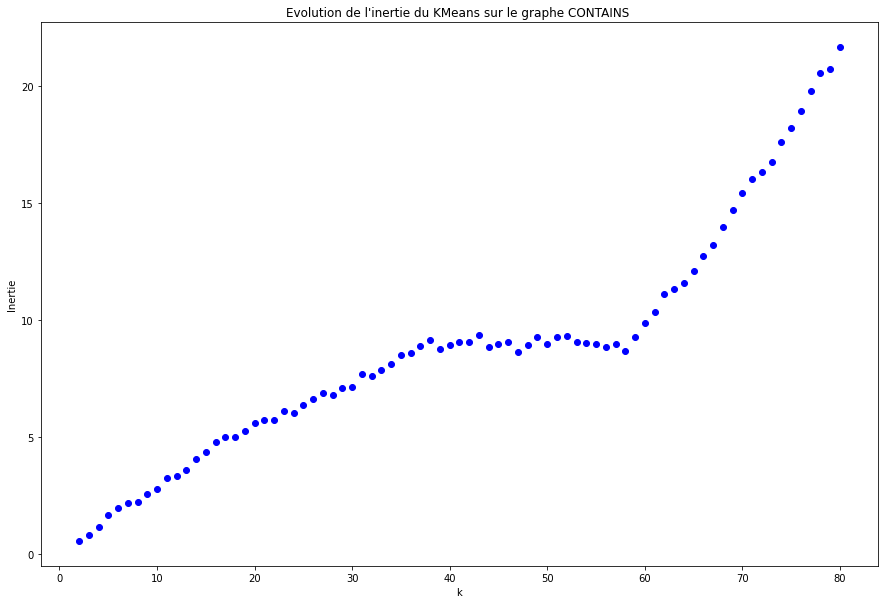

In [26]:
plt.title(f"Evolution de l'inertie du KMeans sur le graphe {relType} {get_graph_info(0,N_in-in_x)}")
plt.xlabel("k")
plt.ylabel("Inertie")
plt.scatter(in_range, inertia[:in_x], color="b")

#Sauvegarde du graphique
#plt.savefig(f"inertie{graph_suffix}{"zoom" if in_x<N_in else ""}.png")

### Calcul du polynôme

In [27]:
in_polyx = range(2,N_in+2)

#### Calcul des coefficients du polynôme pour réaliser les dérivées de l'inertie 

In [28]:
poly_coeffs = np.polyfit(in_polyx, inertia, 8) #Polynôme de degré 8
poly = np.poly1d(poly_coeffs) #Récupération des coefficients

#### Calcul des dérivées du polynôme

On se concentre ici sur les dérivées seconde car on s'intéresse à l'accélération des valeurs d'inertie

In [29]:
poly_deriv = np.polyder(poly,2) #Dérivée seconde du polynôme

#### Trouver les endroits où la dérivée passe par 0

In [30]:
cross_indexes = [] #Points passant par 0
acc_ind = [] #Points d'accélération
dec_ind = [] #Points de décélération

for i in range(N_in-1):
    #Accélération
    if poly_deriv(i) < 0 and poly_deriv(i+1) >= 0:
        acc_ind.append(i+1)
    #Décélération
    elif poly_deriv(i) >= 0 and poly_deriv(i+1) < 0:
        dec_ind.append(i+1)
    
cross_indexes = acc_ind + dec_ind

In [31]:
list(sorted(acc_ind)), list(sorted(dec_ind))

([20, 48, 77], [8, 29, 72])

#### Affichage de la dérivée du graphique d'inertie

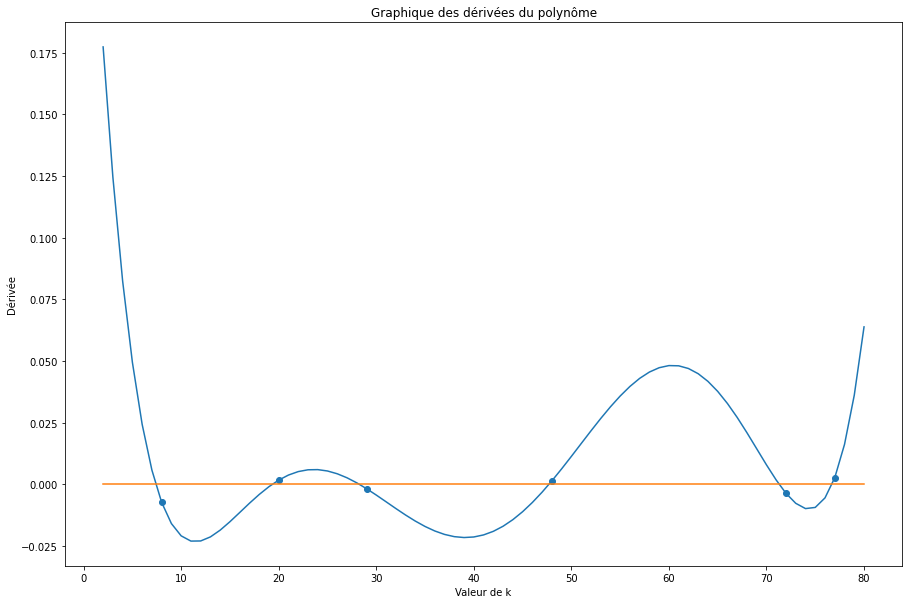

In [32]:
plt.title(f"Graphique des dérivées du polynôme")
plt.xlabel("Valeur de k")
plt.ylabel("Dérivée")
plt.plot(in_polyx, poly_deriv(in_polyx))
plt.plot(in_polyx, np.zeros(N_in))
plt.scatter(cross_indexes, poly_deriv(cross_indexes))

#Sauvegarde du graphique
#plt.savefig(f"inertieDer{graph_suffix}.png")

#### Affichage de l'inertie et du polynôme avec les points d'accélération et de décélération 

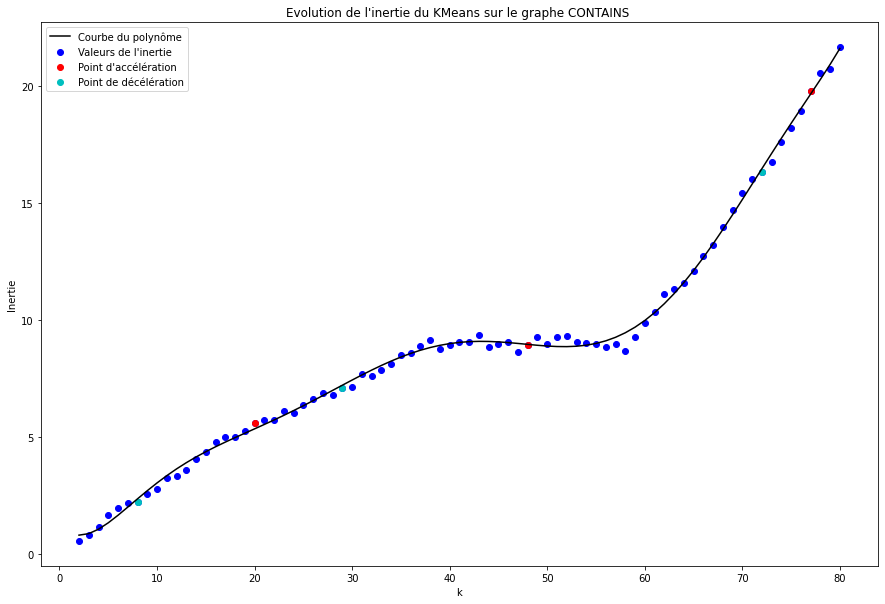

In [33]:
plt.title(f"Evolution de l'inertie du KMeans sur le graphe {relType} {get_graph_info()}")
plt.xlabel("k")
plt.ylabel("Inertie")
plt.plot(in_polyx, poly(in_polyx), color="k", label = "Courbe du polynôme")
plt.scatter(in_polyx, inertia, color="b", label = "Valeurs de l'inertie")
plt.scatter(acc_ind, inertia[[x-2 for x in acc_ind]], color="r", label="Point d'accélération")
plt.scatter(dec_ind, inertia[[x-2 for x in dec_ind]],color="c", label="Point de décélération")
plt.legend()

#plt.savefig(f"inertiePoly{graph_suffix}.png")

### Calcul et affichage de la gaussienne 

In [34]:
from scipy.optimize import curve_fit
from scipy import exp

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = curve_fit(gaus,in_polyx,inertia) #Il est possible que la gaussienne ne puisse pas être fit

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [ ]:
plt.title(f"Evolution de l'inertie du KMeans sur le graphe {relType} {get_graph_info()}")
plt.xlabel("k")
plt.ylabel("Inertie")
plt.scatter(in_polyx, inertia, color="b", label = "Valeurs de l'inertie")
plt.plot(in_polyx, gaus(in_polyx,*popt), label="Gaussienne")
plt.legend()

#Sauvegarde du graphique
#plt.savefig(f"inertieGaus{graph_suffix}.png")

# Graphe du silhouette score 

In [ ]:
silh_x = min(N_silh,81)
silh_range = range(2,silh_x+2)

#### Affichage du silhouette score 

In [ ]:
plt.plot(silh_range, silh[:silh_x], marker=".")
plt.xlabel("n")
plt.ylabel("score")
plt.title(f"Evolution du sihouette score du KMeans sur le graphe {relType} {get_graph_info(0,N_silh-silh_x)}")

#Sauvegarde du graphique
#plt.savefig(f"silh{graph_suffix}{"zoom" if silh_x<N_silh else ""}.png")

#### Comparaison entre silhouette score avec et sans bruit 

In [ ]:
fig, ax = plt.subplots(2)

ax[0].plot(silh_range, silh[:silh_x], marker=".")
ax[0].set_title("Silhouette score bruité")
ax[0].set_xlabel("n")
ax[0].set_ylabel("score")

ax[1].plot(silh_range, silh[:silh_x]-randSilh[:silh_x], marker=".")
ax[1].set_title("Silhouette score non bruité")
ax[1].set_xlabel("n")
ax[1].set_ylabel("score")


plt.suptitle(f"Evolution du sihouette score du KMeans sur le graphe {relType} {get_graph_info(0,N_silh-silh_x)}")

#Sauvegarde du graphique
#plt.savefig(f"silhBruit{graph_suffix}{"zoom" if in_x<N_in else ""}.png")

# Score global

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

#### Inversement + normalisation de l'inertie

In [ ]:
global_x = min(N_silh,81)
global_range = range(2,global_x+2)

norm_inertia = scaler.fit_transform(inertia.reshape(-1,1)).squeeze(1)
norm_inertia_inv = 1-norm_inertia

#### Inversement + normalisation de l'inertie à partir des graphes aléatoires

In [ ]:
norm_randin = scaler.fit_transform(randIn.reshape(-1,1)).squeeze(1)
norm_randin_inv = 1-scaler.fit_transform(randIn.reshape(-1,1)).squeeze(1)

### Création du score global 

##### Score global 

In [ ]:
global_score = norm_inertia_inv[:N_silh]+silh

##### Score global non bruité (obtenu à partir des graphes aléatoires) 

In [ ]:
global_random = scaler.fit_transform((norm_inertia_inv[:N_silh]+silh-norm_randin_inv-randSilh).reshape(-1,1)).squeeze(1)

#### Affichage du score global

In [ ]:
plt.plot(global_range, norm_inertia_inv[:global_x], marker=".", label="inertie")
plt.plot(global_range, silh, marker=".", label="silhouette score")
plt.plot(global_range, global_score[:global_x], marker=".", color="g", label="Score global")


plt.xlabel("n")
plt.ylabel("score")
plt.title(f"Evolution du sihouette score du KMeans sur le graphe {relType} {get_graph_info()}")
plt.legend()

#Sauvegarde du graphique
#plt.savefig(f"global{graph_suffix}.png")

#### Différence entre les mesures et les valeurs de bruit obtenues

In [ ]:
plt.plot(global_range, silh, marker=".", color="b", label="silhouette score")
plt.plot(global_range, randSilh, linestyle="--", color="b", label="silhouette score (bruit)")

plt.plot(global_range, norm_inertia[:global_x], color="g", marker=".", label="inertie")
plt.plot(global_range, norm_randin, linestyle="--", color="g", label="inertie (bruit)")

plt.xlabel("n")
plt.ylabel("score")
plt.title(f"Valeur des mesures et bruit pour le graphe {relType} {get_graph_info(0,N_silh-global_x)}")
plt.legend()

#Sauvegarde du graphique
#plt.savefig(f"mesuresRand{graph_suffix}{"zoom" if global_x<N_silh else ""}.png")

#### Différence entre score global avec et sans bruit 

In [ ]:
plt.plot(global_range, global_score, marker=".", color="b", label="Score global")
plt.plot(global_range, global_random, marker=".", color="g", label="Score global non bruité")
plt.plot(global_range, randSilh+norm_randin_inv, linestyle="--", color="r", label="Score de bruit")


plt.xlabel("n")
plt.ylabel("score")
plt.title(f"Différence entre le score global bruité et non bruité pour le graphe {relType} {get_graph_info()}")
plt.legend()

#Sauvegarde du graphique
#plt.savefig(f"globalComp{graph_suffix}.png")

---------------

# Calcul du score de confiance 

### Calcul du polynôme

In [ ]:
from scipy.optimize import curve_fit
from scipy.stats import norm

In [ ]:
conf_range = range(2,N_silh+2)

In [ ]:
poly_coeffs = np.polyfit(conf_range, global_score, 8)
poly = np.poly1d(poly_coeffs)

#### Calcul des dérivées
Ici on travaille sur la première dérivée pour trouver les maximums (et donc les valeurs candidates) du graphique

In [ ]:
poly_deriv = np.polyder(poly,1)

In [ ]:
print(poly_deriv(conf_range).shape)

#### Trouver les endroits où la dérivée passe par 0

In [ ]:
cross_indexes = [] #Points qui passent par 0 (=maximum)
pos_ind = [] #Points positifs
neg_ind = [] #Points négatifs

for i in range(N_in-1):

    if poly_deriv(i) < 0 and poly_deriv(i+1) >= 0:
        pos_ind.append(i+1)

    elif poly_deriv(i) >= 0 and poly_deriv(i+1) < 0:
        neg_ind.append(i+1)
    
cross_indexes = pos_ind + neg_ind

In [ ]:
list(sorted(pos_ind)), list(sorted(neg_ind))

#### Affichage de la dérivée

In [ ]:
plt.title(f"Graphique des dérivées du polynôme")
plt.xlabel("Valeur de k")
plt.ylabel("Dérivée")

plt.plot(conf_range, poly_deriv(conf_range))
plt.plot(conf_range, np.zeros(N_silh))
plt.scatter(cross_indexes, poly_deriv(cross_indexes))

#Sauvegarde du graphique
#plt.savefig(f"globalDer{graph_suffix}.png")

#### Affichage du score global et du polynôme avec les points d'accélération et de décélération 

In [ ]:
plt.title(f"Allure de la courbe de score global pour le graphe {relType} {get_graph_info()}")
plt.xlabel("Valeur de k")
plt.ylabel("Score global")
plt.plot(conf_range, poly(conf_range), color="k", label = "Courbe du polynôme")
plt.scatter(conf_range, global_score, color="b", label = "Valeurs de combi")
plt.scatter(pos_ind, global_score[[x-2 for x in pos_ind]], color="r", label="Point d'accélération")
plt.scatter(neg_ind, global_score[[x-2 for x in neg_ind]],color="c", label="Point de décélération")
plt.legend()

#Sauvegarde du graphique
#plt.savefig(f"globalPoly{graph_suffix}.png")

---------

### Calcul des gaussiennes 

In [ ]:
def gaus_mul(x, *params):
    """
    Fonction pour pouvoir fit plusieurs gaussiennes sur le graphique donné
    """
    y = np.zeros_like(x)
    for i in range(0,len(params),3):
        a,x0,sigma = params[i:i+3]
        y = y+ a*np.exp(-(x-x0)**2/(2*sigma**2))
        
    return y

guess = []
for sol in dec_ind:
    guess += [global_score[sol],sol,3]
    
print(guess)
#Il est possible que la (ou les) gaussienne(s) ne puisse pas être fit
popt,pcov = curve_fit(gaus_mul, global_range, global_score, p0=guess)

#### Calcul de la probabilité 

In [ ]:
#Pour chaque point x on prend la proba max parmi toutes les gaussiennes qui ont été fit
proba = lambda x, e=1: max((norm(loc = popt[i+1] , scale = popt[i+2]).cdf(x+e) - norm(loc = popt[i+1] , scale = popt[i+2]).cdf(x-e)) for i in range(0,len(popt),3))

#### Affichage du score de confiance 

In [ ]:
color1, color2 = "b", "g"
fig, ax = plt.subplots()

ax.set_title(f"Probabilité de la valeur candidate du score global pour le graphe {relType} {get_graph_info()}")
ax.set_xlabel("Valeur de k")
ax.set_ylabel("Probabilité", color=color1)
ax.plot(global_range, [proba(v) for v in global_range], color=color1)
ax.tick_params(axis="y", labelcolor=color1)

ax2 = ax.twinx()
ax2.set_ylabel("Score global", color=color2)
ax2.plot(global_range, global_score, marker=".", color=color2)
ax2.tick_params(axis="y", labelcolor=color2)

#Sauvegarde du graphique
#plt.savefig(f"globalProba{graph_suffix}.png")